# PV Simulation 

## tests

In [ ]:
# tmy import & save
import pvlib
import pandas as pd 
import constants as c 

pv_gis_data, input_data, meta, additional_info = pvlib.iotools.get_pvgis_tmy(
    latitude=c.BREITENGRAD, 
    longitude=c.LAENGENGRAD, 
    startyear=c.STARTJAHR, 
    endyear=c.ENDJAHR, 
    outputformat='json', 
    usehorizon=True, 
    userhorizon=None, 
    url='https://re.jrc.ec.europa.eu/api/v5_2/', 
    map_variables=True, 
    timeout=30
)

# print(pv_gis_data)
# print(input_data)
# print(meta)
# print(additional_info)

# pv_gis_data['poa_diffuse'] = pv_gis_data['poa_sky_diffuse']+ pv_gis_data['poa_ground_diffuse']
# pv_gis_data['poa_global'] = pv_gis_data['poa_diffuse'] + pv_gis_data['poa_direct']

# pv_gis_data.index = pd.to_datetime(pv_gis_data.index, format="%Y%m%d:H&M") print(pv_gis_data)
pv_gis_data.to_csv("pv_gis_data.csv")

In [ ]:
# formatieren der tmy Daten 
import pandas as pd 

tmy = pd.read_csv("pv_gis_data.csv", 
                 usecols=["time(UTC)", "temp_air", "ghi", "dni", "dhi", "IR(h)", "wind_speed", "wind_direction"],
                  index_col= 0, 
                 )
tmy.index = pd.date_range(
    start= "2021-01-01 00:00", 
        end= "2021-12-31 23:00", 
    freq= "h" 
)


print(tmy)
tmy.plot(figsize = (9,16)) 

In [ ]:
#PVGIS import spezifisches Jahr 
import pvlib
import pandas as pd 
import constants as c 


pv_gis_data, input, meta = pvlib.iotools.get_pvgis_hourly(
    latitude = c.BREITENGRAD, 
    longitude = c.LAENGENGRAD, 
    start=2020, end=2020, 
    raddatabase="PVGIS-SARAH2", components=True, 
    surface_tilt=45, surface_azimuth=0, 
    outputformat='json', usehorizon=True, 
    userhorizon=None, 
    pvcalculation=False, # deaktiviert die PV Kalkulation von PV lib 
    peakpower=None, pvtechchoice='crystSi', 
    mountingplace='free', loss=0, trackingtype=0, 
    optimal_surface_tilt=False, optimalangles=False, 
    url='https://re.jrc.ec.europa.eu/api/v5_2/', 
    map_variables=True, timeout=30)



pv_gis_data['poa_diffuse'] = pv_gis_data['poa_sky_diffuse']+ pv_gis_data['poa_ground_diffuse']
pv_gis_data['poa_global'] = pv_gis_data['poa_diffuse'] + pv_gis_data['poa_direct']

# pv_gis_data.index = pd.to_datetime(pv_gis_data.index, format="%Y%m%d:H&M") print(pv_gis_data)
# pv_gis_data.to_csv("pv_gis_data.csv")

print(pv_gis_data)

In [ ]:
#test mit export Datein 

import tkinter as tk
from tkinter import ttk
from threading import Thread
import constants as c
from functions import berechnung_durchfuehren
from plotting import plot_results

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'tilt': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': '250',
    'gamma_pdc': '-0.004',
    'a_ref': '1.5',
    'Il_ref': '6',
    'I0_ref': '0.001',
    'Rs_ref': '0.5',
    'Rsh_ref': '2000',
    'Adjust': '8.2',
    'Technology': 'monocrystalline',
    'pdc0_inv': '240',
    'eta_inv_nom': '0.96',
    'eta_inv_ref': '0.9637'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['Breitengrad', 'Laengengrad', 'Hoehe', 'tilt', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        tab_control.pack(expand=1, fill="both")

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    def berechnung_thread(self):
        erzeugte_energie, stromerzeugung, berechnungszeit = berechnung_durchfuehren(self.entries)
        if erzeugte_energie is not None and stromerzeugung is not None:
            plot_results(self.root, erzeugte_energie, stromerzeugung, berechnungszeit, self.entries)

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### nur in python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location 
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# Standort definieren (Beispiel: Freiburg, Deutschland)
standort = Location(
    latitude=47.9936,  # Breitengrad
    longitude=7.8522,  # Längengrad
    altitude=278,      # Höhe über dem Meeresspiegel in Metern
    tz='Europe/Berlin' # Zeitzone
)

# Zeitraum für die Berechnung festlegen
startzeit = pd.Timestamp('2024-06-01 00:00:00', tz='Europe/Berlin')
endzeit = pd.Timestamp('2024-06-05 23:59:59', tz='Europe/Berlin')
zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

# Solare Einstrahlung berechnen (minütliche Auflösung)
solare_einstrahlung = standort.get_clearsky(zeit_index)

# Wetterdaten generieren (fiktive Daten)
# In einer realen Anwendung sollten diese Daten aus einer Wetterdatenquelle stammen
temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
windgeschwindigkeit = pd.Series(2, index=zeit_index)

# Berechnung von dni und dhi basierend auf ghi
dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

wetterdaten = pd.DataFrame({
    'temp_air': temperaturen,
    'wind_speed': windgeschwindigkeit,
    'ghi': solare_einstrahlung['ghi'],
    'dni': dni,
    'dhi': dhi
}, index=zeit_index)

# Beispiel: Parameter eines Solarmoduls (fiktive Daten)
modul_parameter = {
    'pdc0': 250,  # Nennleistung (W)
    'gamma_pdc': -0.004,  # Leistungskoeffizient (%/°C)
    'a_ref': 1.5,  # Diode-Parameter
    'Il_ref': 6,   # Leerlaufstrom (A)
    'I0_ref': 0.001,  # Sättigungsstrom (A)
    'Rs_ref': 0.5,  # Serienwiderstand (Ohm)
    'Rsh_ref': 2000,  # Parallelwiderstand (Ohm)
    'Adjust': 8.2,  # Anpassungsfaktor
    'Technology': 'monocrystalline'  # Technologie des Moduls
}

# Beispiel: Parameter eines Wechselrichters (fiktive Daten)
wechselrichter_parameter = {
    'pdc0': 800,  # Nennleistung des Wechselrichters (W)
    'eta_inv_nom': 0.96,  # Wirkungsgrad des Wechselrichters (%)
    'eta_inv_ref': 0.9637  # Referenz-Wirkungsgrad des Wechselrichters (%)
}

# Parameter für das Temperaturmodell
temp_model_params = {
    'u_c': 29.0,  # Verlustfaktor für freistehende Montage (W/m²K)
    'u_v': 0.0   # Windverlustfaktor (W/m²K)/(m/s)
}

# Montagesystem definieren (Beispiel: feste Montierung)
mount = FixedMount(surface_tilt=30, surface_azimuth=180)  # Neigungswinkel: 30°, Azimut: 180° (Süden)

# Erstellung des Arrays mit Temperaturmodell und Montagesystem
array = Array(
    mount=mount, 
    module_parameters=modul_parameter, 
    temperature_model_parameters=temp_model_params, 
    modules_per_string=2)

# Erstellung des PV-Systems mit Arrays
system = PVSystem(
    arrays=[array], 
    inverter_parameters=wechselrichter_parameter)

# Erstellung der ModelChain
mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')

# Durchführung der Simulation
mc.run_model(wetterdaten)

# Berechnung der erzeugten Leistung (in Wh)
ac_power = mc.results.ac
stromerzeugung = mc.results.ac.sum() * (1/60)  # Umwandlung von W zu Wh

print(f"Erzeugte Leistung am 1. Juni 2024 in Freiburg: {stromerzeugung:.2f} Wattstunden")

ac_power.plot()
plt.ylabel('AC Power (W)')
plt.xlabel('Time')
plt.title(f"PV Power Output from {startzeit} bis {endzeit}")
plt.show()

In [ ]:
%reset -f 
%restart -f

### GUI mit plot und default 

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.berechnung_durchfuehren)
        button_berechnen.pack(pady=10)

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            mc.run_model(wetterdaten)

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


verschnellert 

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung, end_time - start_time)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung, berechnungszeit):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        text = f'Berechnungszeit: {berechnungszeit:.2f} Sekunden'
        ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### Schrittweiteneinstellung

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1'  # Standardmäßig 1 Minute Schrittweite
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.create_input_frame()
        self.create_calculation_button()

    def create_input_frame(self):
        frame = tk.Frame(self.root, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        self.entries = {}
        row = 0
        for key, default_value in DEFAULT_VALUES.items():
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, default_value)
            self.entries[key] = entry
            row += 1

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()

    def berechnung_durchfuehren(self):
        try:
            latitude = float(self.entries['latitude'].get())
            longitude = float(self.entries['longitude'].get())
            altitude = float(self.entries['altitude'].get())
            tilt = float(self.entries['tilt'].get())
            azimuth = float(self.entries['azimuth'].get())
            startzeit = pd.Timestamp(self.entries['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(self.entries['endzeit'].get(), tz='Europe/Berlin')
            schrittweite = int(self.entries['schrittweite'].get())

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq=f'{schrittweite}min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': 250,
                'gamma_pdc': -0.004,
                'a_ref': 1.5,
                'Il_ref': 6,
                'I0_ref': 0.001,
                'Rs_ref': 0.5,
                'Rsh_ref': 2000,
                'Adjust': 8.2,
                'Technology': 'monocrystalline'
            }

            wechselrichter_parameter = {
                'pdc0': 240,
                'eta_inv_nom': 0.96,
                'eta_inv_ref': 0.9637
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung, end_time - start_time)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung, berechnungszeit):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        text = f'Berechnungszeit: {berechnungszeit:.2f} Sekunden'
        ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


### GUI mit Reitern und Parameter in der Ergebnissdarstellung 

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'latitude': '47.9936',
    'longitude': '7.8522',
    'altitude': '278',
    'tilt': '30',
    'azimuth': '180',
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': '250',
    'gamma_pdc': '-0.004',
    'a_ref': '1.5',
    'Il_ref': '6',
    'I0_ref': '0.001',
    'Rs_ref': '0.5',
    'Rsh_ref': '2000',
    'Adjust': '8.2',
    'Technology': 'monocrystalline',
    'pdc0_inv': '240',
    'eta_inv_nom': '0.96',
    'eta_inv_ref': '0.9637'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['latitude', 'longitude', 'altitude', 'tilt', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        tab_control.pack(expand=1, fill="both")

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()

    def berechnung_durchfuehren(self):
        try:
            tabs_entries = self.entries  # Alle Einträge aus den Tabs

            latitude = float(tabs_entries[0]['latitude'].get())
            longitude = float(tabs_entries[0]['longitude'].get())
            altitude = float(tabs_entries[0]['altitude'].get())
            tilt = float(tabs_entries[0]['tilt'].get())
            azimuth = float(tabs_entries[0]['azimuth'].get())
            startzeit = pd.Timestamp(tabs_entries[0]['startzeit'].get(), tz='Europe/Berlin')
            endzeit = pd.Timestamp(tabs_entries[0]['endzeit'].get(), tz='Europe/Berlin')
            schrittweite = int(tabs_entries[0]['schrittweite'].get())

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz='Europe/Berlin'
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq=f'{schrittweite}min', tz='Europe/Berlin')

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': float(tabs_entries[1]['pdc0'].get()),
                'gamma_pdc': float(tabs_entries[1]['gamma_pdc'].get()),
                'a_ref': float(tabs_entries[1]['a_ref'].get()),
                'Il_ref': float(tabs_entries[1]['Il_ref'].get()),
                'I0_ref': float(tabs_entries[1]['I0_ref'].get()),
                'Rs_ref': float(tabs_entries[1]['Rs_ref'].get()),
                'Rsh_ref': float(tabs_entries[1]['Rsh_ref'].get()),
                'Adjust': float(tabs_entries[1]['Adjust'].get()),
                'Technology': tabs_entries[1]['Technology'].get()
            }

            wechselrichter_parameter = {
                'pdc0': float(tabs_entries[2]['pdc0_inv'].get()),
                'eta_inv_nom': float(tabs_entries[2]['eta_inv_nom'].get()),
                'eta_inv_ref': float(tabs_entries[2]['eta_inv_ref'].get())
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            print(mc)
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac

            # Ergebnis als Grafik anzeigen
            self.plot_results(stromerzeugung, end_time - start_time, tabs_entries)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, stromerzeugung, berechnungszeit, tabs_entries):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        text = f"Berechnungszeit: {berechnungszeit:.2f} Sekunden\n\nEingabeparameter:\n"
        for tab_entries in tabs_entries:
            for key, entry in tab_entries.items():
                text += f"{key.capitalize()}: {entry.get()}\n"
            text += "\n"

        text += "\nErzeugte Leistung:\n"
        text += str(stromerzeugung)

        label = tk.Label(ergebnis_win, text=text, justify='left')
        label.pack(padx=10, pady=10)

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from threading import Thread
import time

import constants as c
from functions import *

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'tilt': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': '2024-06-01 00:00:00',
    'endzeit': '2024-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': '250',
    'gamma_pdc': '-0.004',
    'a_ref': '1.5',
    'Il_ref': '6',
    'I0_ref': '0.001',
    'Rs_ref': '0.5',
    'Rsh_ref': '2000',
    'Adjust': '8.2',
    'Technology': 'monocrystalline',
    'pdc0_inv': '240',
    'eta_inv_nom': '0.96',
    'eta_inv_ref': '0.9637'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['Breitengrad', 'Laengengrad', 'Hoehe', 'tilt', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        tab_control.pack(expand=1, fill="both")

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_durchfuehren)
        thread.start()
        # # printed die ModelChain
        # print(mc)

    def berechnung_durchfuehren(self):
        try:
            tabs_entries = self.entries  # Alle Einträge aus den Tabs

            latitude = float(tabs_entries[0]['Breitengrad'].get())
            longitude = float(tabs_entries[0]['Laengengrad'].get())
            altitude = float(tabs_entries[0]['Hoehe'].get())
            tilt = float(tabs_entries[0]['tilt'].get())
            azimuth = float(tabs_entries[0]['azimuth'].get())
            startzeit = pd.Timestamp(tabs_entries[0]['startzeit'].get(), tz=c.ZEITZONE)
            endzeit = pd.Timestamp(tabs_entries[0]['endzeit'].get(), tz=c.ZEITZONE)
            schrittweite = int(tabs_entries[0]['schrittweite'].get())

            standort = Location(
                latitude=latitude,
                longitude=longitude,
                altitude=altitude,
                tz=c.ZEITZONE
            )

            zeit_index = pd.date_range(start=startzeit, end=endzeit, freq=f'{schrittweite}min', tz=c.ZEITZONE)

            solare_einstrahlung = standort.get_clearsky(zeit_index)

            temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
            windgeschwindigkeit = pd.Series(2, index=zeit_index)

            dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
            dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

            wetterdaten = pd.DataFrame({
                'temp_air': temperaturen,
                'wind_speed': windgeschwindigkeit,
                'ghi': solare_einstrahlung['ghi'],
                'dni': dni,
                'dhi': dhi
            }, index=zeit_index)

            modul_parameter = {
                'pdc0': float(tabs_entries[1]['pdc0'].get()),
                'gamma_pdc': float(tabs_entries[1]['gamma_pdc'].get()),
                'a_ref': float(tabs_entries[1]['a_ref'].get()),
                'Il_ref': float(tabs_entries[1]['Il_ref'].get()),
                'I0_ref': float(tabs_entries[1]['I0_ref'].get()),
                'Rs_ref': float(tabs_entries[1]['Rs_ref'].get()),
                'Rsh_ref': float(tabs_entries[1]['Rsh_ref'].get()),
                'Adjust': float(tabs_entries[1]['Adjust'].get()),
                'Technology': tabs_entries[1]['Technology'].get()
            }

            wechselrichter_parameter = {
                'pdc0': float(tabs_entries[2]['pdc0_inv'].get()),
                'eta_inv_nom': float(tabs_entries[2]['eta_inv_nom'].get()),
                'eta_inv_ref': float(tabs_entries[2]['eta_inv_ref'].get())
            }

            temp_model_params = {
                'u_c': 29.0,
                'u_v': 0.0
            }

            mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)

            array = Array(mount=mount, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
            system = PVSystem(arrays=[array], inverter_parameters=wechselrichter_parameter)

            mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
            
            start_time = time.time()
            mc.run_model(wetterdaten)
            end_time = time.time()

            stromerzeugung = mc.results.ac
            erzeugte_energie = stromerzeugung.sum() * schrittweite / 60 / 1000  # in kWh umrechnen

            # Ergebnis als Grafik anzeigen
            self.plot_results(erzeugte_energie, stromerzeugung, end_time - start_time, tabs_entries)

        except Exception as e:
            messagebox.showerror("Fehler", f"Ein Fehler ist aufgetreten: {e}")

    def plot_results(self, erzeugte_energie, stromerzeugung, berechnungszeit, tabs_entries):
        ergebnis_win = tk.Toplevel(self.root)
        ergebnis_win.title("Ergebnis der Stromerzeugung")

        text = f"Berechnungszeit: {berechnungszeit:.2f} Sekunden\n\n"

        # Eingabeparameter anzeigen
        text += "Eingabeparameter:\n\n"
        for tab_entries in tabs_entries:
            for key, entry in tab_entries.items():
                text += f"{key.capitalize()}: {entry.get()}\n"
            text += "\n"

        # Erzeugte Energie anzeigen
        text += f"Erzeugte Energie: {erzeugte_energie:.2f} kWh\n"

        label = tk.Label(ergebnis_win, text=text, justify='left')
        label.pack(padx=10, pady=10)

        # Plot der Stromerzeugung
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(stromerzeugung.index, stromerzeugung, label='Erzeugte Leistung (W)')
        ax.set_xlabel('Zeit')
        ax.set_ylabel('Leistung (W)')
        ax.set_title('Stromerzeugung')
        ax.legend()
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=ergebnis_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


Simulation soll auf basis von tmy erstellt werde, damit die Ergebnisse vergleichbar bleiben. TMY Daten müssen immer für jeden Ort inividuell abgerufen werden. nach dem Abruffen sollen sie als csv gespeichert werden. bei jeder erneuten Simulation soll überprüft werden ob Daten schon vorhanden sind (Demnach Längen- & Breitengrad mit in Dateinamen

In [ ]:
import tkinter as tk
from tkinter import ttk
from threading import Thread
import constants as c
from functions import berechnung_durchfuehren
from plotting import plot_results

# Standardwerte für die Eingabefelder
DEFAULT_VALUES = {
    'Breitengrad': c.BREITENGRAD,
    'Laengengrad': c.LAENGENGRAD,
    'Hoehe': c.HOEHE,
    'Anstellwinkel': c.ANSTELLWINKEL,
    'azimuth': c.AZIMUTH,
    'startzeit': '2021-06-01 00:00:00',
    'endzeit': '2021-06-01 23:59:59',
    'schrittweite': '1',  # Standardmäßig 1 Minute Schrittweite
    'pdc0': '250',
    'gamma_pdc': '-0.004',
    'a_ref': '1.5',
    'Il_ref': '6',
    'I0_ref': '0.001',
    'Rs_ref': '0.5',
    'Rsh_ref': '2000',
    'Adjust': '8.2',
    'Technology': 'monocrystalline',
    'pdc0_inv': '240',
    'eta_inv_nom': '0.96',
    'eta_inv_ref': '0.9637'
}

class PVLeistungsberechnung:
    def __init__(self, root):
        self.root = root
        self.root.title("PV-Leistungsberechnung")

        self.tabs = []
        self.entries = []

        self.create_tabs()
        self.create_calculation_button()

    def create_tabs(self):
        tab_control = ttk.Notebook(self.root)
        
        # Tab für allgemeine Einstellungen
        tab1 = ttk.Frame(tab_control)
        tab_control.add(tab1, text='Allgemein')
        self.create_input_frame(tab1, ['Breitengrad', 'Laengengrad', 'Hoehe', 'Anstellwinkel', 'azimuth', 'startzeit', 'endzeit', 'schrittweite'])
        self.tabs.append(tab1)

        # Tab für Modulparameter
        tab2 = ttk.Frame(tab_control)
        tab_control.add(tab2, text='Modulparameter')
        self.create_input_frame(tab2, ['pdc0', 'gamma_pdc', 'a_ref', 'Il_ref', 'I0_ref', 'Rs_ref', 'Rsh_ref', 'Adjust', 'Technology'])
        self.tabs.append(tab2)

        # Tab für Wechselrichterparameter
        tab3 = ttk.Frame(tab_control)
        tab_control.add(tab3, text='Wechselrichterparameter')
        self.create_input_frame(tab3, ['pdc0_inv', 'eta_inv_nom', 'eta_inv_ref'])
        self.tabs.append(tab3)

        tab_control.pack(expand=1, fill="both")

    def create_input_frame(self, frame, keys):
        frame = tk.Frame(frame, padx=10, pady=10)
        frame.pack(padx=10, pady=10)

        entries = {}
        row = 0
        for key in keys:
            label = tk.Label(frame, text=f"{key.capitalize()}:")
            label.grid(row=row, column=0, sticky=tk.W)
            entry = tk.Entry(frame)
            entry.grid(row=row, column=1)
            entry.insert(0, DEFAULT_VALUES[key])
            entries[key] = entry
            row += 1

        self.entries.append(entries)

    def create_calculation_button(self):
        button_berechnen = tk.Button(self.root, text="Berechnen", command=self.starte_berechnung)
        button_berechnen.pack(pady=10)

    def starte_berechnung(self):
        thread = Thread(target=self.berechnung_thread)
        thread.start()

    def berechnung_thread(self):
        erzeugte_energie, stromerzeugung, berechnungszeit = berechnung_durchfuehren(self.entries)
        if erzeugte_energie is not None and stromerzeugung is not None:
            plot_results(self.root, erzeugte_energie, stromerzeugung, berechnungszeit, self.entries)
            

if __name__ == "__main__":
    root = tk.Tk()
    app = PVLeistungsberechnung(root)
    root.mainloop()


In [ ]:
# test mit externer py Datei 

import constants as c 
# import functions as fnc
from functions import *

placeholder()

print(c.BREITENGRAD)
print(c.LAENGENGRAD)
print(c.ZEITZONE)

## Test für Zelt PV 

Erzeugte Leistung am 1. Juni 2024 in Freiburg: 15091.63 Wattstunden


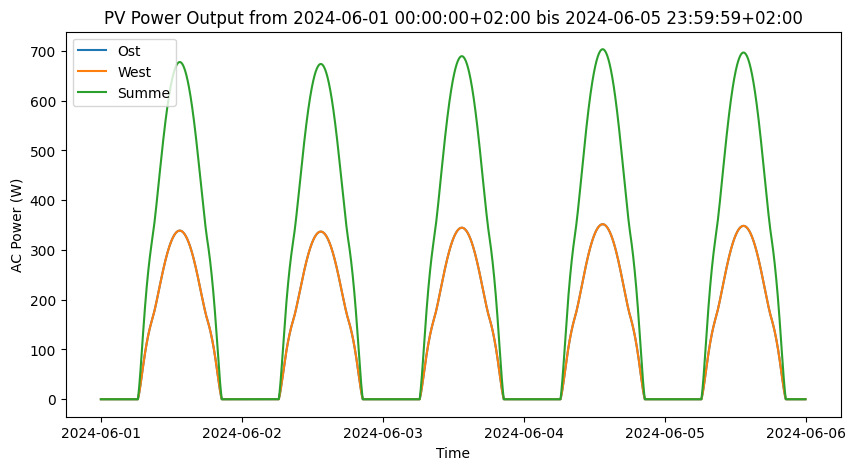

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location

# Standort definieren (Beispiel: Freiburg, Deutschland)
standort = Location(
    latitude=47.9936,  # Breitengrad
    longitude=7.8522,  # Längengrad
    altitude=278,      # Höhe über dem Meeresspiegel in Metern
    tz='Europe/Berlin' # Zeitzone
)

# Zeitraum für die Berechnung festlegen
startzeit = pd.Timestamp('2024-06-01 00:00:00', tz='Europe/Berlin')
endzeit = pd.Timestamp('2024-06-05 23:59:59', tz='Europe/Berlin')
zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

# Solare Einstrahlung berechnen (minütliche Auflösung)
solare_einstrahlung = standort.get_clearsky(zeit_index)

# Wetterdaten generieren (fiktive Daten)
# In einer realen Anwendung sollten diese Daten aus einer Wetterdatenquelle stammen
temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
windgeschwindigkeit = pd.Series(2, index=zeit_index)

# Berechnung von dni und dhi basierend auf ghi
dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

wetterdaten = pd.DataFrame({
    'temp_air': temperaturen,
    'wind_speed': windgeschwindigkeit,
    'ghi': solare_einstrahlung['ghi'],
    'dni': dni,
    'dhi': dhi
}, index=zeit_index)

# Beispiel: Parameter eines Solarmoduls (fiktive Daten)
modul_parameter = {
    'pdc0': 250,  # Nennleistung (W)
    'gamma_pdc': -0.004,  # Leistungskoeffizient (%/°C)
    'a_ref': 1.5,  # Diode-Parameter
    'Il_ref': 6,   # Leerlaufstrom (A)
    'I0_ref': 0.001,  # Sättigungsstrom (A)
    'Rs_ref': 0.5,  # Serienwiderstand (Ohm)
    'Rsh_ref': 2000,  # Parallelwiderstand (Ohm)
    'Adjust': 8.2,  # Anpassungsfaktor
    'Technology': 'monocrystalline'  # Technologie des Moduls
}

# Beispiel: Parameter eines Wechselrichters (fiktive Daten)
wechselrichter_parameter = {
    'pdc0': 2340,  # Nennleistung des Wechselrichters (W)
    'eta_inv_nom': 0.96,  # Wirkungsgrad des Wechselrichters (%)
    'eta_inv_ref': 0.9637  # Referenz-Wirkungsgrad des Wechselrichters (%)
}

# Parameter für das Temperaturmodell
temp_model_params = {
    'u_c': 29.0,  # Verlustfaktor für freistehende Montage (W/m²K)
    'u_v': 0.0   # Windverlustfaktor (W/m²K)/(m/s)
}

# Montagesystem definieren für Ost- und Westausrichtung
mount_east = FixedMount(surface_tilt=30, surface_azimuth=90)  # Ost-Ausrichtung
mount_west = FixedMount(surface_tilt=30, surface_azimuth=270)  # West-Ausrichtung

# Erstellung der Arrays mit Temperaturmodell und Montagesystem
array_east = Array(mount=mount_east, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)
array_west = Array(mount=mount_west, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params)

# Erstellung des PV-Systems mit beiden Arrays
system = PVSystem(arrays=[array_east, array_west], inverter_parameters=wechselrichter_parameter)


pv_system_east = PVSystem(array_east, inverter_parameters=wechselrichter_parameter)
pv_system_west = PVSystem(array_west, inverter_parameters=wechselrichter_parameter)

# Erstellung der ModelChain
mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')


mc_east = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')
mc_west = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')

# Durchführung der Simulation
mc.run_model(wetterdaten)


mc_east.run_model(wetterdaten)
mc_west.run_model(wetterdaten)


# Berechnung der erzeugten Leistung (in Wh)
ac_power = mc.results.ac
stromerzeugung = mc.results.ac.sum() * (1/60)  # Umwandlung von W zu Wh

mc_east_power = mc_east.results.ac



print(f"Erzeugte Leistung am 1. Juni 2024 in Freiburg: {stromerzeugung:.2f} Wattstunden")

plt.figure(figsize=(10, 5))
# ac_power.plot()


# mc_east_power.plot()
plt.plot(mc_east.results.ac.index, mc_east.results.ac, label='Ost')
plt.plot(mc_west.results.ac.index, mc_west.results.ac, label='West')
plt.plot(mc_east.results.ac.index, mc_east.results.ac + mc_west.results.ac, label='Summe')


plt.ylabel('AC Power (W)')
plt.xlabel('Time')
plt.legend()
plt.title(f"PV Power Output from {startzeit} bis {endzeit}")
plt.show()


C:\Users\Caj\AppData\Local\Temp\ipykernel_34848\2913213694.py:14: RuntimeWarning: invalid value encountered in log
  y7 = np.log(x)  # Logarithmische Funktion (Achtung: x muss positiv sein)


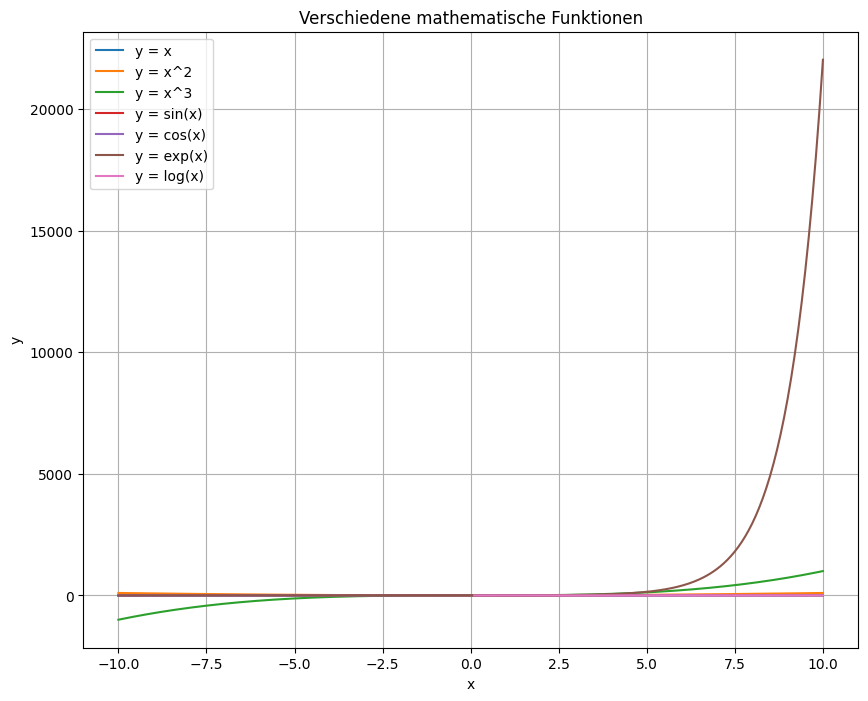

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Erstellen Sie einen Bereich von x-Werten
x = np.linspace(-10, 10, 400)

# Definieren Sie verschiedene Funktionen
y1 = x  # Lineare Funktion
y2 = x**2  # Quadratische Funktion
y3 = x**3  # Kubische Funktion
y4 = np.sin(x)  # Sinus-Funktion
y5 = np.cos(x)  # Kosinus-Funktion
y6 = np.exp(x)  # Exponentialfunktion
y7 = np.log(x)  # Logarithmische Funktion (Achtung: x muss positiv sein)

# Erstellen Sie die Plots
plt.figure(figsize=(10, 8))

plt.plot(x, y1, label='y = x')
plt.plot(x, y2, label='y = x^2')
plt.plot(x, y3, label='y = x^3')
plt.plot(x, y4, label='y = sin(x)')
plt.plot(x, y5, label='y = cos(x)')
plt.plot(x, y6, label='y = exp(x)')

# Beachten Sie, dass log(x) nur für positive Werte von x definiert ist
# Daher plotten wir log(x) separat mit einem begrenzten Bereich von x-Werten
x_positive = np.linspace(0.1, 10, 400)
y7_positive = np.log(x_positive)
plt.plot(x_positive, y7_positive, label='y = log(x)')

# Beschriftungen und Titel hinzufügen
plt.xlabel('x')
plt.ylabel('y')
plt.title('Verschiedene mathematische Funktionen')
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.modelchain import ModelChain
from pvlib.location import Location

# Standort definieren (Beispiel: Freiburg, Deutschland)
standort = Location(
    latitude=47.9936,  # Breitengrad
    longitude=7.8522,  # Längengrad
    altitude=278,      # Höhe über dem Meeresspiegel in Metern
    tz='Europe/Berlin' # Zeitzone
)

# Zeitraum für die Berechnung festlegen
startzeit = pd.Timestamp('2024-06-01 00:00:00', tz='Europe/Berlin')
endzeit = pd.Timestamp('2024-06-05 23:59:59', tz='Europe/Berlin')
zeit_index = pd.date_range(start=startzeit, end=endzeit, freq='1min', tz='Europe/Berlin')

# Solare Einstrahlung berechnen (minütliche Auflösung)
solare_einstrahlung = standort.get_clearsky(zeit_index)

# Wetterdaten generieren (fiktive Daten)
# In einer realen Anwendung sollten diese Daten aus einer Wetterdatenquelle stammen
temperaturen = pd.Series(20 + 5 * np.sin(np.linspace(0, 2 * np.pi, len(zeit_index))), index=zeit_index)
windgeschwindigkeit = pd.Series(2, index=zeit_index)

# Berechnung von dni und dhi basierend auf ghi
dni = pvlib.irradiance.erbs(solare_einstrahlung['ghi'], standort.get_solarposition(zeit_index)['apparent_zenith'], zeit_index)['dni']
dhi = solare_einstrahlung['ghi'] - dni * np.cos(np.radians(standort.get_solarposition(zeit_index)['apparent_zenith']))

wetterdaten = pd.DataFrame({
    'temp_air': temperaturen,
    'wind_speed': windgeschwindigkeit,
    'ghi': solare_einstrahlung['ghi'],
    'dni': dni,
    'dhi': dhi
}, index=zeit_index)

# Beispiel: Parameter eines Solarmoduls (fiktive Daten)
modul_parameter = {
    'pdc0': 250,  # Nennleistung (W)
    'gamma_pdc': -0.004,  # Leistungskoeffizient (%/°C)
    'a_ref': 1.5,  # Diode-Parameter
    'Il_ref': 6,   # Leerlaufstrom (A)
    'I0_ref': 0.001,  # Sättigungsstrom (A)
    'Rs_ref': 0.5,  # Serienwiderstand (Ohm)
    'Rsh_ref': 2000,  # Parallelwiderstand (Ohm)
    'Adjust': 8.2,  # Anpassungsfaktor
    'Technology': 'monocrystalline'  # Technologie des Moduls
}

# Beispiel: Parameter eines Wechselrichters (fiktive Daten)
wechselrichter_parameter = {
    'pdc0': 800,  # Nennleistung des Wechselrichters (W)
    'eta_inv_nom': 0.96,  # Wirkungsgrad des Wechselrichters (%)
    'eta_inv_ref': 0.9637  # Referenz-Wirkungsgrad des Wechselrichters (%)
}

# Parameter für das Temperaturmodell
temp_model_params = {
    'u_c': 29.0,  # Verlustfaktor für freistehende Montage (W/m²K)
    'u_v': 0.0   # Windverlustfaktor (W/m²K)/(m/s)
}

# Montagesystem definieren für Ost- und Westausrichtung
mount_east = FixedMount(surface_tilt=30, surface_azimuth=90)  # Ost-Ausrichtung
mount_west = FixedMount(surface_tilt=30, surface_azimuth=270)  # West-Ausrichtung

# Erstellung der Arrays mit Temperaturmodell und Montagesystem
array_east = Array(mount=mount_east, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params, modules_per_string=1)
array_west = Array(mount=mount_west, module_parameters=modul_parameter, temperature_model_parameters=temp_model_params, modules_per_string=1)

# Erstellung des PV-Systems mit beiden Arrays
system = PVSystem(arrays=[array_east, array_west], inverter_parameters=wechselrichter_parameter)

# Erstellung der ModelChain
mc = ModelChain(system, standort, aoi_model='physical', spectral_model='no_loss')

# Durchführung der Simulation
mc.run_model(wetterdaten)

# Berechnung der erzeugten Leistung (in Wh)
ac_power = mc.results.ac
stromerzeugung = mc.results.ac.sum() * (1/60)  # Umwandlung von W zu Wh

print(f"Erzeugte Leistung am 1. Juni 2024 in Freiburg: {stromerzeugung:.2f} Wattstunden")

ac_power.plot()
plt.ylabel('AC Power (W)')
plt.xlabel('Time')
plt.title(f"PV Power Output from {startzeit} bis {endzeit}")
plt.show()


## Datenbanken für PV und Inverter

In [ ]:
import pvlib

# Laden der PV-Modul-Datenbank
module_db = pvlib.pvsystem.retrieve_sam('CECMod')
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_module_db = pvlib.pvsystem.retrieve_sam('CECMod')

# Anzeigen der verfügbaren Module
print(module_db.columns)

# Laden der Wechselrichter-Datenbank
cec_inverter_db = pvlib.pvsystem.retrieve_sam('cecinverter')


# Anzeigen der verfügbaren Wechselrichter
print(cec_inverter_db.columns)
# Ein bestimmtes Modul aus der Datenbank auswählen
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
print(module)

# Einen bestimmten Wechselrichter aus der Datenbank auswählen
inverter = cec_inverter_db['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
print(inverter)


In [ ]:
%reset -f

In [ ]:
# Variabeln im Workspace 
%whos

## Trys from pvlib Page 

In [ ]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt


coordinates = [
    (32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),
    (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),
    (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
]



sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)
system = {'module': module, 'inverter': inverter,
          'surface_azimuth': 180}


energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)


print(energies)






energies.plot(kind='bar', rot=0)


plt.ylabel('Yearly energy yield (W hr)')


In [ ]:
from pvlib.pvsystem import PVSystem, Array, FixedMount

from pvlib.location import Location

from pvlib.modelchain import ModelChain

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)


print(energies)






energies.plot(kind='bar', rot=0)


plt.ylabel('Yearly energy yield (W hr)')


# PV-Moduldatenbank

## Entwürfe

In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib

class ModuleSelectorApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Sandia Module Selector")
        self.geometry("600x400")

        self.modules = pvlib.pvsystem.retrieve_sam('sandiamod')
        self.module_names = sorted(self.modules.columns)

        self.create_widgets()

    def create_widgets(self):
        self.label = tk.Label(self, text="Select a PV Module:")
        self.label.pack(pady=10)

        self.module_var = tk.StringVar()
        self.module_dropdown = ttk.Combobox(self, textvariable=self.module_var)
        self.module_dropdown['values'] = self.module_names
        self.module_dropdown.bind('<<ComboboxSelected>>', self.on_module_selected)
        self.module_dropdown.pack(pady=10)

        self.module_details = tk.Text(self, wrap='word', height=15, width=70)
        self.module_details.pack(pady=10)

    def on_module_selected(self, event):
        selected_module = self.module_var.get()
        module_data = self.modules[selected_module]
        
        details = f"Module: {selected_module}\n"
        for attr, value in module_data.items():
            details += f"{attr}: {value}\n"

        self.module_details.delete(1.0, tk.END)
        self.module_details.insert(tk.END, details)

if __name__ == "__main__":
    app = ModuleSelectorApp()
    app.mainloop()


In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib

class ModuleSelectorApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Sandia Module Selector")
        self.geometry("600x400")

        self.modules = pvlib.pvsystem.retrieve_sam('sandiamod')
        self.module_names = sorted(self.modules.columns)

        self.create_widgets()

    def create_widgets(self):
        self.label = tk.Label(self, text="Select a PV Module:")
        self.label.pack(pady=10)

        self.module_var = tk.StringVar()
        self.module_var.trace_add('write', self.update_dropdown)
        self.module_dropdown = ttk.Combobox(self, textvariable=self.module_var)
        self.module_dropdown['values'] = self.module_names
        self.module_dropdown.bind('<<ComboboxSelected>>', self.on_module_selected)
        self.module_dropdown.pack(pady=10)

        self.module_details = tk.Text(self, wrap='word', height=15, width=70)
        self.module_details.pack(pady=10)

    def update_dropdown(self, *args):
        current_text = self.module_var.get()
        filtered_modules = [module for module in self.module_names if current_text.lower() in module.lower()]
        self.module_dropdown['values'] = filtered_modules

    def on_module_selected(self, event):
        selected_module = self.module_var.get()
        module_data = self.modules[selected_module]
        
        details = f"Module: {selected_module}\n"
        for attr, value in module_data.items():
            details += f"{attr}: {value}\n"

        self.module_details.delete(1.0, tk.END)
        self.module_details.insert(tk.END, details)

if __name__ == "__main__":
    app = ModuleSelectorApp()
    app.mainloop()


In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib

class ModuleSelectorApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Sandia Module Selector")
        self.geometry("600x400")

        self.modules = pvlib.pvsystem.retrieve_sam('sandiamod')
        self.module_names = sorted(self.modules.columns)

        self.create_widgets()

    def create_widgets(self):
        self.label = tk.Label(self, text="Select a PV Module:")
        self.label.pack(pady=10)

        self.module_var = tk.StringVar()
        self.module_var.trace_add('write', self.update_dropdown)
        self.module_dropdown = ttk.Combobox(self, textvariable=self.module_var)
        self.module_dropdown['values'] = self.module_names
        self.module_dropdown.pack(pady=10)

        self.module_details = tk.Text(self, wrap='word', height=15, width=70)
        self.module_details.pack(pady=10)

    def update_dropdown(self, *args):
        current_text = self.module_var.get()
        filtered_modules = [module for module in self.module_names if current_text.lower() in module.lower()]
        self.module_dropdown['values'] = filtered_modules

    def on_module_selected(self, event):
        selected_module = self.module_var.get()
        module_data = self.modules[selected_module]
        
        details = f"Module: {selected_module}\n"
        for attr, value in module_data.items():
            details += f"{attr}: {value}\n"

        self.module_details.delete(1.0, tk.END)
        self.module_details.insert(tk.END, details)

if __name__ == "__main__":
    app = ModuleSelectorApp()
    app.mainloop()


die Suchfunktion sieht wie folgt aus. es gibt ein Eingabefeld wo nach Modulen gesucht wird darunter ist dann ein weiteres Fenster wo die Module aufgelistet werden die mit der suche der Eingabe am besten übereinstimmen. 
Nach der Auswahl eines Moduls sollen darunter alle Eigenschaften angezeigt und aufgelistet werden

In [ ]:
import pandas as pd
import pvlib

# Laden der Sandia-Moduldatenbank direkt mit retrieve_sam() und dem Namen 'sandiamod'
sandia_modules = pvlib.pvsystem.retrieve_sam(name='sandiamod')

# Konvertieren in einen DataFrame
df = pd.DataFrame(sandia_modules)

# Anzeigen des DataFrames
# print(df.shape)
# print(df.head())
# print(df.columns)
# print(df.describe())
df.to_excel('sandiamod.xlsx', sheet_name='Sheet1', index=True)

print(df.info())
print(df)


In [ ]:
# funktionier nur darstellung 
import tkinter as tk
from tkinter import ttk
import pvlib

# Daten aus der Sandia-Moduldatenbank laden
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# GUI erstellen
class ModuleDatabaseApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sandia Moduldatenbank")
        
        # Erstellen der Treeview für die Anzeige der Daten
        self.tree = ttk.Treeview(self.root)
        self.tree["columns"] = ("Vintage", "Area", "Material", "Cells_in_Series",
                                "Parallel_Strings", "Isco", "Voco", "Impo", "Vmpo")
        
        # Festlegen der Spaltenüberschriften
        self.tree.heading("#0", text="Modul")
        self.tree.column("#0", width=150)
        
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100)
        
        # Einfügen der Daten in die Treeview
        for module, data in sandia_modules.items():
            self.tree.insert("", "end", text=module, values=(
                data['Vintage'], data['Area'], data['Material'],
                data['Cells_in_Series'], data['Parallel_Strings'],
                data['Isco'], data['Voco'], data['Impo'], data['Vmpo']
            ))
        
        # Packen der Treeview
        self.tree.pack(pady=10, padx=10)
        
        # Schließen-Button
        self.close_button = ttk.Button(self.root, text="Schließen", command=self.root.quit)
        self.close_button.pack(pady=10)

# Hauptprogramm
if __name__ == "__main__":
    root = tk.Tk()
    app = ModuleDatabaseApp(root)
    root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib

# Daten aus der Sandia-Moduldatenbank laden
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# GUI erstellen
class ModuleDatabaseApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sandia Moduldatenbank")
        
        self.create_widgets()
        
        # Daten für die Anzeige
        self.displayed_modules = list(sandia_modules.keys())  # Alle Module zu Beginn anzeigen
        
        # Einfügen der Daten in die Treeview
        self.update_displayed_modules()

    def create_widgets(self):
        # Suchfeld
        self.search_var = tk.StringVar()
        self.search_var.trace("w", self.update_displayed_modules)
        self.search_entry = ttk.Entry(self.root, textvariable=self.search_var)
        self.search_entry.pack(padx=10, pady=10, fill=tk.X)

        # Treeview für die Anzeige der Daten
        self.tree = ttk.Treeview(self.root)
        self.tree["columns"] = ("Vintage", "Area", "Material", "Cells_in_Series",
                                "Parallel_Strings", "Isco", "Voco", "Impo", "Vmpo")
        
        # Festlegen der Spaltenüberschriften
        self.tree.heading("#0", text="Modul")
        self.tree.column("#0", width=150)
        
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100)
        
        # Packen der Treeview
        self.tree.pack(pady=10, padx=10)

        # Schließen-Button
        self.close_button = ttk.Button(self.root, text="Schließen", command=self.root.destroy)
        self.close_button.pack(pady=10)

    def update_displayed_modules(self, *args):
        # Funktion zum Aktualisieren der angezeigten Module basierend auf der Sucheingabe
        search_text = self.search_var.get().lower()  # Suchtext ohne Groß-/Kleinschreibung

        # Filtern der Module
        self.displayed_modules = [module for module in sandia_modules
                                  if search_text in module.lower()]

        # Löschen aller bestehenden Einträge in der Treeview
        self.tree.delete(*self.tree.get_children())

        # Einfügen der gefilterten Module in die Treeview
        for module in self.displayed_modules:
            data = sandia_modules[module]
            self.tree.insert("", "end", text=module, values=(
                data['Vintage'], data['Area'], data['Material'],
                data['Cells_in_Series'], data['Parallel_Strings'],
                data['Isco'], data['Voco'], data['Impo'], data['Vmpo']
            ))

# Hauptprogramm
if __name__ == "__main__":
    root = tk.Tk()
    app = ModuleDatabaseApp(root)
    root.mainloop()


klick auf einträge möglich noch keine richtige Darstellung

In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib
import numpy as np

# Daten aus der Sandia-Moduldatenbank laden
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# GUI erstellen
class ModuleDatabaseApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sandia Moduldatenbank")
        
        self.create_widgets()
        
        # Daten für die Anzeige
        self.displayed_modules = list(sandia_modules.keys())  # Alle Module zu Beginn anzeigen
        
        # Einfügen der Daten in die Treeview
        self.update_displayed_modules()
        
        # Doppelklick-Event für Treeview-Einträge
        self.tree.bind("<Double-1>", self.on_double_click)

    def create_widgets(self):
        # Suchfeld
        self.search_var = tk.StringVar()
        self.search_var.trace("w", self.update_displayed_modules)
        self.search_entry = ttk.Entry(self.root, textvariable=self.search_var)
        self.search_entry.pack(padx=10, pady=10, fill=tk.X)

        # Treeview für die Anzeige der Daten
        self.tree = ttk.Treeview(self.root)
        self.tree["columns"] = ("Vintage", "Area", "Material", "Cells_in_Series",
                                "Parallel_Strings", "Isco", "Voco", "Impo", "Vmpo")
        
        # Festlegen der Spaltenüberschriften
        self.tree.heading("#0", text="Modul")
        self.tree.column("#0", width=150)
        
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100)
        
        # Packen der Treeview
        self.tree.pack(pady=10, padx=10)

        # Schließen-Button
        self.close_button = ttk.Button(self.root, text="Schließen", command=self.root.destroy)
        self.close_button.pack(pady=10)

    def update_displayed_modules(self, *args):
        # Funktion zum Aktualisieren der angezeigten Module basierend auf der Sucheingabe
        search_text = self.search_var.get().lower()  # Suchtext ohne Groß-/Kleinschreibung

        # Filtern der Module
        self.displayed_modules = [module for module in sandia_modules
                                  if search_text in module.lower()]

        # Löschen aller bestehenden Einträge in der Treeview
        self.tree.delete(*self.tree.get_children())

        # Einfügen der gefilterten Module in die Treeview
        for module in self.displayed_modules:
            data = sandia_modules[module]
            self.tree.insert("", "end", text=module, values=(
                data['Vintage'], data['Area'], data['Material'],
                data['Cells_in_Series'], data['Parallel_Strings'],
                data['Isco'], data['Voco'], data['Impo'], data['Vmpo']
            ))

    def on_double_click(self, event):
        # Funktion, die aufgerufen wird, wenn ein Eintrag in der Treeview doppelt geklickt wird
        item = self.tree.selection()[0]  # Auswahl des Eintrags
        module_name = self.tree.item(item, "text")  # Name des Moduls aus dem Textattribut des Eintrags

        # Neues Fenster für die Detailansicht des Moduls
        module_details_window = tk.Toplevel(self.root)
        module_details_window.title(f"Details für Modul: {module_name}")

        # Treeview für die Detailansicht
        detail_tree = ttk.Treeview(module_details_window)
        detail_tree["columns"] = list(sandia_modules[module_name].keys())

        # Festlegen der Spaltenüberschriften
        for col in detail_tree["columns"]:
            detail_tree.heading(col, text=col)
            detail_tree.column(col, width=100)

        # Vorbereiten der Daten für das ausgewählte Modul
        module_data = sandia_modules[module_name]
        values = []
        for key in detail_tree["columns"]:
            value = module_data[key]
            if isinstance(value, np.ndarray):
                # Wenn der Wert ein ndarray ist, konvertieren wir ihn zu einer lesbaren Zeichenfolge
                value_str = np.array2string(value, precision=4, separator=', ')
                values.append(value_str)
            else:
                values.append(str(value))

        # Einfügen der Daten für das ausgewählte Modul
        detail_tree.insert("", "end", text=module_name, values=values)

        # Packen der Treeview für die Detailansicht
        detail_tree.pack(padx=10, pady=10)

# Hauptprogramm
if __name__ == "__main__":
    root = tk.Tk()
    app = ModuleDatabaseApp(root)
    root.mainloop()


mit doppelklick aber labeldarstellung 

In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib
import numpy as np

# Daten aus der Sandia-Moduldatenbank laden
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# GUI erstellen
class ModuleDatabaseApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sandia Moduldatenbank")
        
        self.create_widgets()
        
        # Daten für die Anzeige
        self.displayed_modules = list(sandia_modules.keys())  # Alle Module zu Beginn anzeigen
        
        # Einfügen der Daten in die Treeview
        self.update_displayed_modules()
        
        # Doppelklick-Event für Treeview-Einträge
        self.tree.bind("<Double-1>", self.on_double_click)

    def create_widgets(self):
        # Suchfeld
        self.search_var = tk.StringVar()
        self.search_var.trace("w", self.update_displayed_modules)
        self.search_entry = ttk.Entry(self.root, textvariable=self.search_var)
        self.search_entry.pack(padx=10, pady=10, fill=tk.X)

        # Treeview für die Anzeige der Daten
        self.tree = ttk.Treeview(self.root)
        self.tree["columns"] = ("Vintage", "Area", "Material", "Cells_in_Series",
                                "Parallel_Strings", "Isco", "Voco", "Impo", "Vmpo")
        
        # Festlegen der Spaltenüberschriften
        self.tree.heading("#0", text="Modul")
        self.tree.column("#0", width=150)
        
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100)
        
        # Packen der Treeview
        self.tree.pack(pady=10, padx=10)

        # Schließen-Button
        self.close_button = ttk.Button(self.root, text="Schließen", command=self.root.quit)
        self.close_button.pack(pady=10)

    def update_displayed_modules(self, *args):
        # Funktion zum Aktualisieren der angezeigten Module basierend auf der Sucheingabe
        search_text = self.search_var.get().lower()  # Suchtext ohne Groß-/Kleinschreibung

        # Filtern der Module
        self.displayed_modules = [module for module in sandia_modules
                                  if search_text in module.lower()]

        # Löschen aller bestehenden Einträge in der Treeview
        self.tree.delete(*self.tree.get_children())

        # Einfügen der gefilterten Module in die Treeview
        for module in self.displayed_modules:
            data = sandia_modules[module]
            self.tree.insert("", "end", text=module, values=(
                data['Vintage'], data['Area'], data['Material'],
                data['Cells_in_Series'], data['Parallel_Strings'],
                data['Isco'], data['Voco'], data['Impo'], data['Vmpo']
            ))

    def on_double_click(self, event):
        # Funktion, die aufgerufen wird, wenn ein Eintrag in der Treeview doppelt geklickt wird
        item = self.tree.selection()[0]  # Auswahl des Eintrags
        module_name = self.tree.item(item, "text")  # Name des Moduls aus dem Textattribut des Eintrags

        # Neues Fenster für die Detailansicht des Moduls
        module_details_window = tk.Toplevel(self.root)
        module_details_window.title(f"Details für Modul: {module_name}")

        # Frame für die Detailansicht
        detail_frame = ttk.Frame(module_details_window)
        detail_frame.pack(padx=10, pady=10)

        # Überschriften und Werte in Grid-Layout einfügen
        row = 0
        for key, value in sandia_modules[module_name].items():
            ttk.Label(detail_frame, text=key, font=("Arial", 12, "bold")).grid(row=row, column=0, sticky=tk.W, padx=5, pady=2)
            ttk.Label(detail_frame, text=str(value)).grid(row=row, column=1, sticky=tk.W, padx=5, pady=2)
            row += 1

# Hauptprogramm
if __name__ == "__main__":
    root = tk.Tk()
    app = ModuleDatabaseApp(root)
    root.mainloop()


mit doppelklick und tree darstellung 

In [ ]:
import tkinter as tk
from tkinter import ttk
import pvlib
import numpy as np

# Daten aus der Sandia-Moduldatenbank laden
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# GUI erstellen
class ModuleDatabaseApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sandia Moduldatenbank")
        
        self.create_widgets()
        
        # Daten für die Anzeige
        self.displayed_modules = list(sandia_modules.keys())  # Alle Module zu Beginn anzeigen
        
        # Einfügen der Daten in die Treeview
        self.update_displayed_modules()
        
        # Doppelklick-Event für Treeview-Einträge
        self.tree.bind("<Double-1>", self.on_double_click)

    def create_widgets(self):
        # Suchfeld
        self.search_var = tk.StringVar()
        self.search_var.trace("w", self.update_displayed_modules)
        self.search_entry = ttk.Entry(self.root, textvariable=self.search_var)
        self.search_entry.pack(padx=10, pady=10, fill=tk.X)

        # Treeview für die Anzeige der Module
        self.tree = ttk.Treeview(self.root)
        self.tree["columns"] = ("Vintage", "Area", "Material", "Cells_in_Series",
                                "Parallel_Strings", "Isco", "Voco", "Impo", "Vmpo")
        
        # Festlegen der Spaltenüberschriften
        self.tree.heading("#0", text="Modul")
        self.tree.column("#0", width=150)
        
        for col in self.tree["columns"]:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100)
        
        # Packen der Treeview
        self.tree.pack(pady=10, padx=10)

        # Schließen-Button
        self.close_button = ttk.Button(self.root, text="Schließen", command=self.root.quit)
        self.close_button.pack(pady=10)

    def update_displayed_modules(self, *args):
        # Funktion zum Aktualisieren der angezeigten Module basierend auf der Sucheingabe
        search_text = self.search_var.get().lower()  # Suchtext ohne Groß-/Kleinschreibung

        # Filtern der Module
        self.displayed_modules = [module for module in sandia_modules
                                  if search_text in module.lower()]

        # Löschen aller bestehenden Einträge in der Treeview
        self.tree.delete(*self.tree.get_children())

        # Einfügen der gefilterten Module in die Treeview
        for module in self.displayed_modules:
            data = sandia_modules[module]
            self.tree.insert("", "end", text=module, values=(
                data['Vintage'], data['Area'], data['Material'],
                data['Cells_in_Series'], data['Parallel_Strings'],
                data['Isco'], data['Voco'], data['Impo'], data['Vmpo']
            ))

    def on_double_click(self, event):
        # Funktion, die aufgerufen wird, wenn ein Eintrag in der Treeview doppelt geklickt wird
        item = self.tree.selection()[0]  # Auswahl des Eintrags
        module_name = self.tree.item(item, "text")  # Name des Moduls aus dem Textattribut des Eintrags

        # Neues Fenster für die Detailansicht des Moduls
        module_details_window = tk.Toplevel(self.root)
        module_details_window.title(f"Details für Modul: {module_name}")

        # Treeview für die Detailansicht
        detail_tree = ttk.Treeview(module_details_window)
        detail_tree["columns"] = ("Wert")
        detail_tree.heading("#0", text="Parameter")
        detail_tree.column("#0", width=150)
        detail_tree.heading("Wert", text="Wert")
        detail_tree.column("Wert", width=200)

        # Daten für das ausgewählte Modul
        module_data = sandia_modules[module_name]

        # Einfügen der Daten in den Treeview
        for key, value in module_data.items():
            detail_tree.insert("", "end", text=key, values=(str(value)))

        # Packen der Treeview für die Detailansicht
        detail_tree.pack(padx=10, pady=10)

# Hauptprogramm
if __name__ == "__main__":
    root = tk.Tk()
    app = ModuleDatabaseApp(root)
    root.mainloop()
